In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani

In [2]:
num_patterns = 2
def MNIST_load(num_patterns):
    from keras.datasets import mnist
    (X, y), (_, _ )= mnist.load_data()
    idx = np.random.randint(len(X), size = num_patterns)
    X = X[idx]
    y = y[idx]
    X = (X > 128).astype(int)
    X = np.where(X == 0, -1, 1).astype(int)
    X = X.reshape(-1, 784)
    y = y.astype(np.int32)

    return X, y

In [3]:
X, y = MNIST_load(num_patterns)

2024-09-25 12:35:45.427071: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 12:35:45.427100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 12:35:45.428012: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-25 12:35:45.433786: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-25 12:35:46.101314: W tensorflow/compiler/tf2

In [4]:
class Hopfield_Net:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.n = X.shape[1] #neuron count
        self.num_pattern = X.shape[0]
        self.W = np.zeros((self.n, self.n))
        #μ = np.sum([np.sum(x) for x in X]) / (self.n * self.num_pattern)
        self.all_states = [] #To use if reconstructing (animation)
        print("Starting training.")

        for i in range(self.num_pattern):
            x = X[i]# - μ
            self.W += np.outer(x.T, x)
        np.fill_diagonal(self.W, 0)
        self.W /= self.num_pattern

    def inference(self, X, n_iter, b = 0):
        """
        X -> data
        n_iter -> number of iterations
        b -> threshold value
        """        
        print("Starting inference.")
        self.n_iter = n_iter
        self.b = b
        preds = []

        for i in range(X.shape[0]):
            preds.append(self.state_update(X[i]))
        return preds

    def energy(self, x):
        return -0.5 * np.dot(x, np.dot(self.W, x)) + np.sum(x * self.b)

    def state_update(self, x, sync = False, track_states = True):
        x_ = x.copy()
        energy = self.energy(x_)
        self.states = [x_.copy()] #Tracking all states over iters
        
        if sync: #Synchronous update
            for _ in range(self.n_iter):
                x_ = np.sign(np.dot(self.W, x_) - self.b)
                energy_new = self.energy(x_)
                if track_states:
                    self.states.append(x_.copy())
                if energy_new == energy:
                    return x_
                energy = energy_new
            self.all_states.append(self.states)
            return x_
            
        else: #Asynchronous update
            for _ in range(self.n_iter):
                for _ in range(200): #n of neurons to update per iter
                    idx = np.random.randint(self.n)
                    x_[idx] = np.sign(np.dot(self.W[idx], x_) - self.b)
                    if track_states:
                        self.states.append(x_.copy())
                energy_new = self.energy(x_)
                if energy_new == energy:
                    self.all_states.append(self.states)
                    return x_
                energy = energy_new
            self.all_states.append(self.states)
            return x_
        
    
    def weight_plot(self):
        w = plt.imshow(self.W, cmap="hot")
        plt.colorbar(w)
        plt.axis("off")
        plt.show()
        
    def reconstruction(self, dif = 1, save_path = "patterns/HP_ani"):
        # dif : interval (ms)
        for i in range(len(self.all_states)):
            print(f"Reconstructing from noisy pattern {i}")
            ims = []
            fig, ax = plt.subplots()
            ims.append([ax.imshow(self.all_states[i][0].reshape((28, 28)), cmap="gray", animated = True)])
            ax.imshow(self.all_states[i][0].reshape((28, 28)), cmap="gray", animated = True)
            for j in range(1, len(self.all_states[i])):
                ims.append([ax.imshow(self.all_states[i][j].reshape((28, 28)), cmap="gray", animated = True)])
    
            anim = ani.ArtistAnimation(fig, ims, interval=dif, blit=True, repeat_delay=1000)
            plt.title("Reconstruction")
            plt.axis("off")
        
            if save_path:
                anim.save(f"{save_path}_pat{i}.gif", writer="pillow", fps=1000/dif)
            plt.show()

    def original_patterns(self, save_path = "patterns/pattern"):
        #Save original patterns
        plt.figure(figsize=(4, 4))
        for i in range(self.num_pattern):
            plt.imshow(self.X[i].reshape(28, 28), cmap="gray")
            plt.title(f"Original, label: {self.y[i]}")
            plt.axis("off")
            plt.savefig(f"{save_path}_{i}.png", bbox_inches="tight", pad_inches=0)
            plt.close()

In [5]:
def add_noise(X, noise_level=0.2):
    X_noisy = X.copy()
    n_pixels_change = int(X.shape[1] * noise_level)
    for i in range(X.shape[0]):
        rnd_idxs = np.random.randint(X.shape[1], size=n_pixels_change)
        X_noisy[i, rnd_idxs] = -X_noisy[i, rnd_idxs] #Flip bits
    return X_noisy

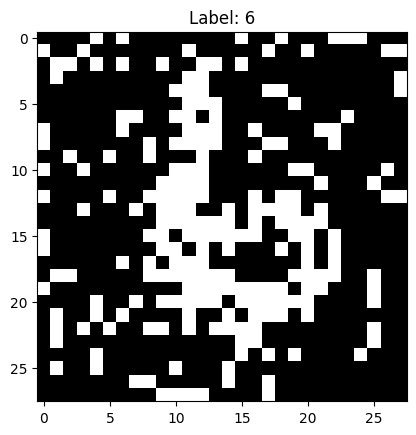

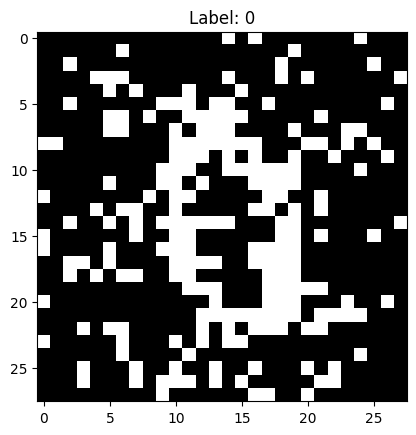

In [6]:
#Testing noise
X_noisy = add_noise(X)
for i in range(num_patterns):
    plt.imshow(X_noisy[i].reshape(28, 28), cmap="gray")
    plt.title(f"Label: {y[i]}")
    plt.show()


In [7]:
net = Hopfield_Net(X, y)
preds = net.inference(X_noisy, 20)
#net.reconstruction(save_path = "HP_ani")
net.original_patterns()

Starting training.
Starting inference.


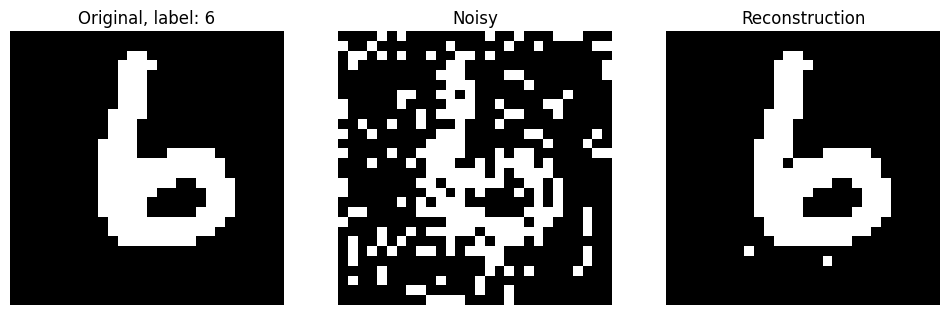

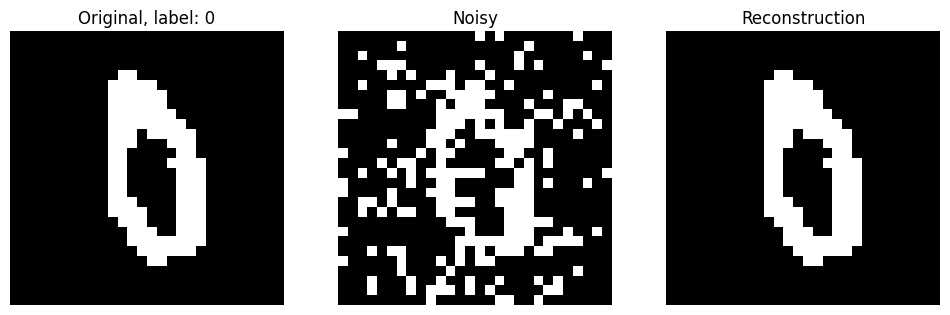

In [8]:
for i in range(num_patterns):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(X[i].reshape(28, 28), cmap="gray")
    plt.title(f"Original, label: {y[i]}")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(X_noisy[i].reshape(28, 28), cmap="gray")
    plt.title("Noisy")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(preds[i].reshape(28, 28), cmap="gray")
    plt.title("Reconstruction")
    plt.axis("off")
    plt.show()

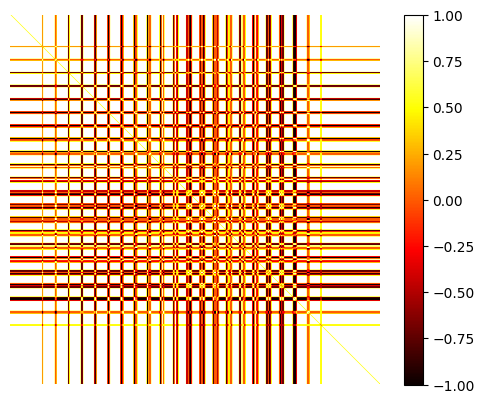

In [9]:
net.weight_plot()